## Семинар 4: "Сверточные сети"

ФИО: Косарев Е.А.

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [55]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    for i in range(signal_convolved.shape[0]):
        signal_convolved[i] = np.sum(kernel[::-1] * signal[i: i + kernel.shape[0]])
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [56]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

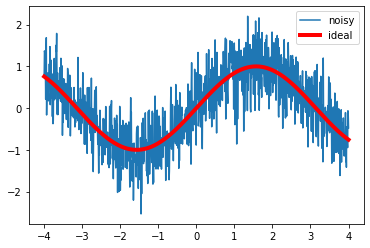

In [57]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [72]:
size = 5
kernel = np.ones((size)) / size
denoised_signal = convolve(noisy_signal, kernel, 'same')

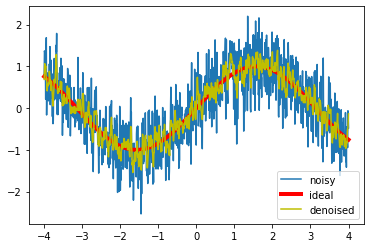

In [73]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [69]:
best_i = -1
best_res = 1e10

for i in range(5, 100):
    size = i
    kernel = np.ones((size)) / size
    denoised_signal = convolve(noisy_signal, kernel, 'same')
    res = np.sqrt(np.mean((signal - denoised_signal) ** 2))
    if res < best_res:
        best_i = i
        best_res = res
    print('ker_size = {}, RMSE = {}'.format(size, res))

ker_size = 5, RMSE = 0.21660336825389448
ker_size = 6, RMSE = 0.19487930072990503
ker_size = 7, RMSE = 0.17980965673456678
ker_size = 8, RMSE = 0.16769663115532787
ker_size = 9, RMSE = 0.1575195235548302
ker_size = 10, RMSE = 0.14853856177718783
ker_size = 11, RMSE = 0.1398684755748167
ker_size = 12, RMSE = 0.13242879854500522
ker_size = 13, RMSE = 0.12604719672482526
ker_size = 14, RMSE = 0.11994809934161893
ker_size = 15, RMSE = 0.11468088705351125
ker_size = 16, RMSE = 0.10958077772704786
ker_size = 17, RMSE = 0.10575451718774494
ker_size = 18, RMSE = 0.10222548596989794
ker_size = 19, RMSE = 0.09937772056894931
ker_size = 20, RMSE = 0.09661101929216458
ker_size = 21, RMSE = 0.0944566913430045
ker_size = 22, RMSE = 0.0924075306484356
ker_size = 23, RMSE = 0.09047231133928942
ker_size = 24, RMSE = 0.08882561663480047
ker_size = 25, RMSE = 0.08694980672353564
ker_size = 26, RMSE = 0.08540791242625233
ker_size = 27, RMSE = 0.08386041662849683
ker_size = 28, RMSE = 0.08266001300771661
k

In [70]:
print('best ker_size = {}, best RMSE = {}'.format(best_i, best_res))

best ker_size = 55, best RMSE = 0.06892582699324411


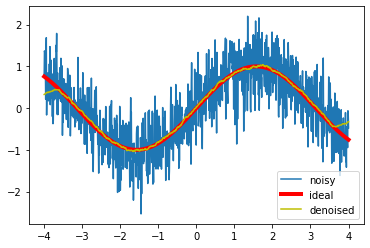

In [71]:
kernel = np.ones((size)) / size
denoised_signal = convolve(noisy_signal, kernel, 'same')
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

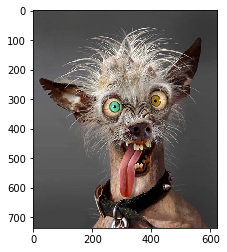

In [142]:
image = plt.imread('sobaken.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [143]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

In [144]:
image.shape, image.flatten().shape

((736, 624, 3), (1377792,))

In [145]:
convolve(image.reshape(-1, ), color_to_bw, 'same').shape

(1377792,)

(736, 624)


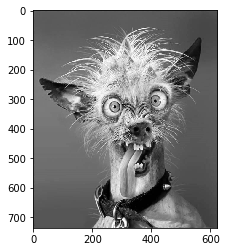

In [146]:
bw_image = convolve(image.reshape(-1, ), color_to_bw, 'same').reshape(image.shape)[:,:,0]
print(bw_image.shape)
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

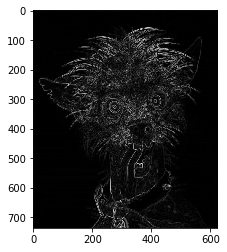

In [147]:
from scipy.signal import convolve2d

kernel = np.array([[-1, -2, -1],
                   [0,   0,  0],
                   [+1, +2, +1]])

res_y = convolve2d(bw_image, kernel.T, 'same')
res_x = convolve2d(bw_image, kernel, 'same')

plt.imshow((res_x**2 + res_y**2)**0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [148]:
# [h, w, 3] -> [h, w, 4]
# ker.shape = [3, a, b, 4]

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    signal = signal.copy()
    ans = []
    for i in range(kernel.shape[-1]):
        layer = np.zeros_like(signal[:, :, i])
        for j in range(signal.shape[-1]):
            layer += convolve2d(signal[:,:,j], kernel[j,:,:,i], mode='same')
        
        ans.append(layer)
    return np.array(ans).transpose(1, 2 , 0)

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [149]:
#RGB -> BGR

kernel = np.zeros((3, 1, 1, 3))

kernel[2,0,0,0] = 1
kernel[1,0,0,1] = 1
kernel[0,0,0,2] = 1

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

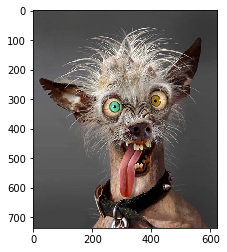

In [150]:
plt.imshow(image)

(736, 624, 3)


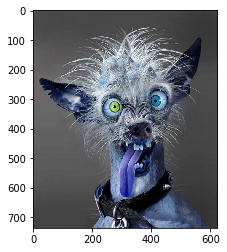

In [154]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

res_img = t_convolve_bank(image.astype('float'), kernel)
print(image.shape)
plt.imshow(res_img.astype('uint8'))

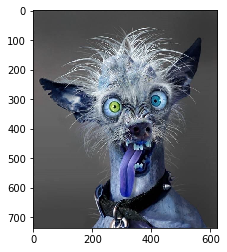

In [160]:
import cv2
im_cv = cv2.imread('sobaken.jpg')
plt.imshow(im_cv)

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [43]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, res.shape[0]):
        for j in range(0, res.shape[1]):
            for k in range(res.shape[2]):
                res[i, j, k] = np.max(image[i*w:i*w+w, j*w:j*w+w, k])
                
    return res

def medianpool(image, w=2):
    assert(image.ndim == 3)
    res = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    for i in range(0, res.shape[0]):
        for j in range(0, res.shape[1]):
            for k in range(res.shape[2]):
                res[i, j, k] = np.median(image[i*w:i*w+w, j*w:j*w+w, k])
    return res

(73, 62, 3)


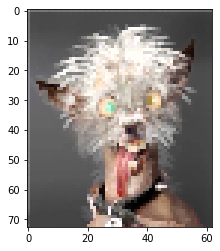

In [38]:
image = plt.imread('sobaken.jpg')
res_image = maxpool(image.astype(float), w = 10)

plt.imshow(res_image.astype('uint8'))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

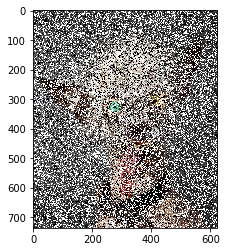

In [39]:
frac = 0.7

res_image = np.array(image)

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 0

ind = np.random.rand(*image.shape[:2]) > frac
res_image[ind, :] = 255

plt.imshow(res_image.astype('uint8'))

Text(0.5, 1.0, 'median_pooling')

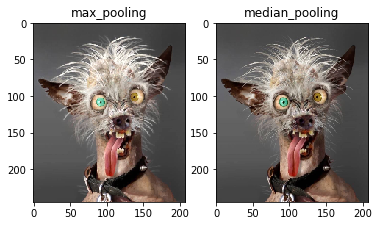

In [47]:
image = plt.imread('sobaken.jpg')
res_image = maxpool(image.astype(float), w = 3)
median_image = medianpool(image.astype(float), w = 3)

fig, ax = plt.subplots(1, 2, )
ax[0].imshow(res_image.astype('uint8'))
ax[0].set_title('max_pooling')
ax[1].imshow(median_image.astype('uint8'))
ax[1].set_title('median_pooling')


<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [53]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [56]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.size(0), x.shape, type(x))
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [57]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.235/0.218	Accuracy: 0.932/0.937


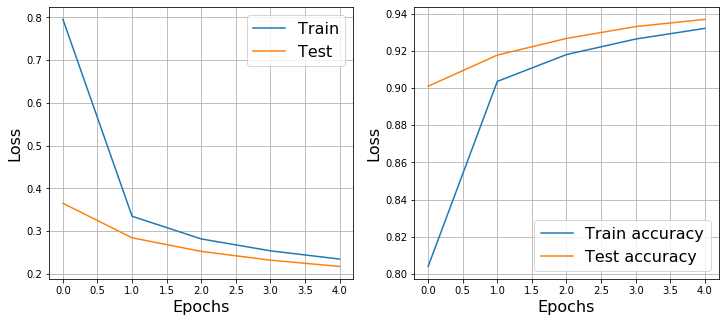

In [58]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

1. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
2. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

In [71]:
image_size = 28
channels = 1
class ConvNet1(nn.Module):
    def __init__(self, image_size):
        super(ConvNet1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2), 
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(), 
                                        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*16, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self, image_size):
        super(ConvNet2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding = 1)
                                        )
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.089/0.077	Accuracy: 0.974/0.977


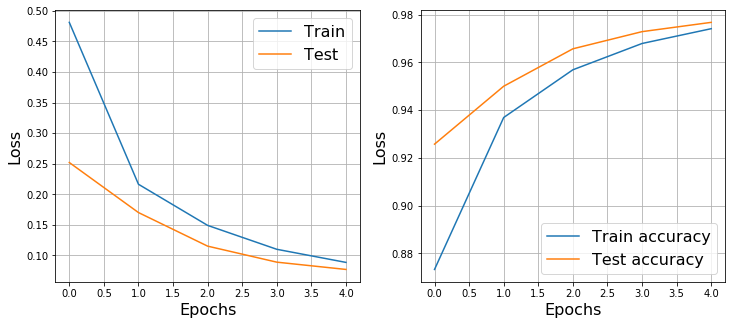

In [64]:
nn1 = ConvNet1(image_size=28)
train(nn1, 5, 1e-4)

Epoch 4... (Train/Test) NLL: 0.067/0.058	Accuracy: 0.980/0.982


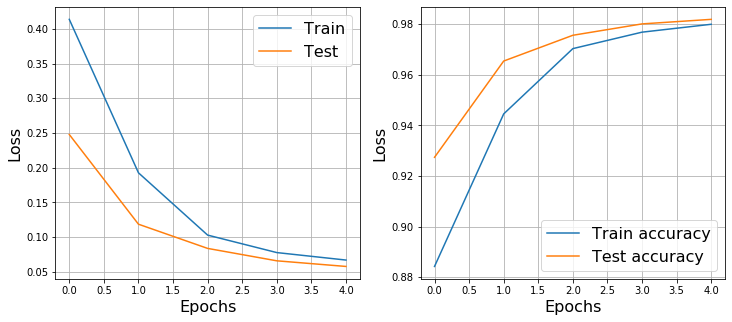

In [72]:
nn2 = ConvNet2(image_size=28)
train(nn2, 5, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [109]:
def show_ers(nn):
    batch = next(iter(test_loader))
    X, y = batch
    pred = np.exp(nn(X).detach().numpy())
    #softmax
    pred = pred / np.sum(pred, axis = 0)
    #got probas
    pred = np.argmax(pred, axis= 1)
    plt.figure(figsize=(16, 7))
    for i in range(32):
        plt.subplot(4, 8, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title("{} - pred{}".format(y[i], pred[i]))
        plt.axis('off')    

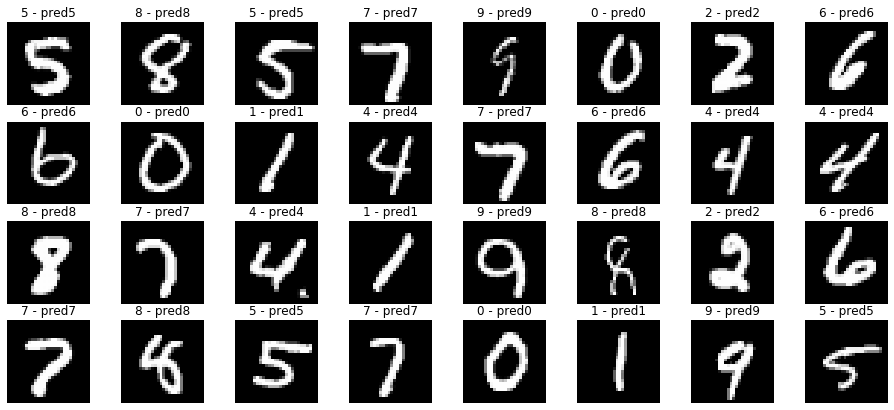

In [110]:
show_ers(nn1)

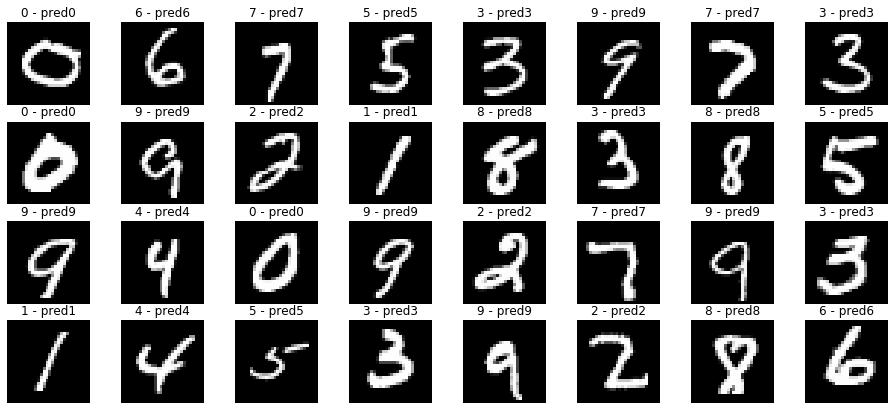

In [111]:
show_ers(nn2)

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [208]:
class My_NET(nn.Module):
    def __init__(self, image_size):
        super(My_NET, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 16, 7, padding=3), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 64, 5, padding=2), 
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(64, 128, 5, padding = 2),
                                         nn.ReLU(), 
                                        )
        tmp = 4
        self.linear_layers = nn.Sequential(nn.Linear(image_size//tmp*image_size//tmp*128, 128),
                                           nn.ReLU(),
                                           nn.Linear(128, 64),
                                           nn.ReLU(),
                                           nn.Linear(64, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.031/0.031	Accuracy: 0.990/0.990


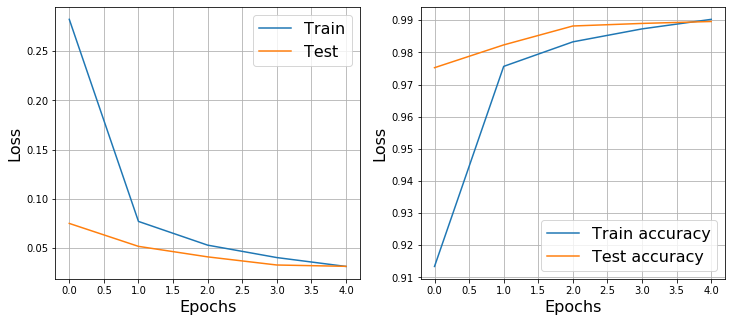

In [209]:
my = My_NET(image_size=28)
train(my, 5, 1e-4)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: